# Genome Mining Notebook
### Nathan Alam 7/7/2020

Run through the steps after installing the pre-requisite MEME software

## Configuration

Here are the parameters that you should edit for each run. The **runName** will be the name of the run, the **pattern** is the pattern to search lasso peptides against, the **cutoffRank** is the minimum required rank to run, the **genomeDir** is the directory where the FASTA and FNA files to be mined are stored, the **database** is where you would like the database to be written to, and **outputLogs** is where the output should be written to.

**models** is a list of models to generate motifs for and search with.

**memeDir** is the directory where the meme suite was installed on this computer, and **localMotifDir** is some empty or nonexistent directory that this program can use as scratch space.

In [19]:
import yaml
config = yaml.safe_load('''
# Setup parameters for a genome mining run

## Parameters for each run
runName: "test2"
pattern: 'M[A-Z]{15,45}T[A-Z][A-Z]{6,8}[DE][A-Z]{5,30}\*'
cutoffRank: 0
genomeDir: "/home/blucheez/Projects/lassomining/genomes/"
database: "/home/blucheez/Projects/lassomining/output/matches.db"
outputLogs: "/home/blucheez/Projects/lassomining/output/runs/"
models:
  - location: "/home/blucheez/Projects/lassomining/models/b.faa"
    numOfMotifs: 3
    maxWidth: 25
  - location: "/home/blucheez/Projects/lassomining/models/c.faa"
    numOfMotifs: 4
    maxWidth: 25
  
## Parameters you should not have to change
memeDir: "/home/blucheez/meme"
localMotifDir: "/home/blucheez/Projects/lassomining/storage/scratch/"
''')

Below is a lot of the logic behind the mining, but just provides a series of functions to be used in the following code block

## Mining
Here are the commands for actually running the genome mining software. Output is printed below this block as it progresses, and this is the slowest running part of the program.

In [22]:
import traceback
import sys
import os
import time
import shutil
import json
from pathlib import Path
from mining import mine

In [23]:
runName = config["runName"]
pattern = config["pattern"]
cutoffRank = config["cutoffRank"]
genomeDir = config["genomeDir"]
databaseDir = config["database"]
runDir = config["outputLogs"]
memeJobs = []
for model in config["models"]:
    memeJobs.append([
            model["location"],
            model["numOfMotifs"],
            model["maxWidth"]
        ])

localMotifDir = config["localMotifDir"]
memeDir = config["memeDir"]

print("Beginning run " + runName)
print("cutting off hits below " + str(cutoffRank))
print("searching for pattern " + pattern)
print("Meme jobs to be run:")
print(memeJobs)
print("Genomes being read from " + str(genomeDir))
print("writing output to " + databaseDir)

try:
    # check if the localMotifDir exists
    if not os.path.exists(localMotifDir):
        print("creating a folder " + localMotifDir + " for temporary files")
        os.makedirs(localMotifDir)
    # Generate motifs and store them in localMotifDir
    for memeJob in memeJobs:
        memeName = memeJob[0].split("/")
        modelDir = "/".join(memeName[0: len(memeName) - 1]) + "/"
        memeName = memeName[len(memeName) - 1]
        model = memeName
        memeName = memeName[0: len(memeName) - 4]
        nmotifs = memeJob[1]
        width = memeJob[2]
        print("creating meme motifs for " + memeName)
        print("reading from " + modelDir + model)
        command = memeDir + "/bin/meme -nmotifs " + str(nmotifs) + " -maxw " + str(width) + " " + modelDir + model + " -o " + localMotifDir + memeName
        print(command)
        os.system(command)
    
        os.rename(localMotifDir + memeName + "/meme.txt", localMotifDir + memeName + "Results.txt")
        shutil.rmtree(localMotifDir + memeName)
except Exception as error:
    print("An error occured while running MEME")
    traceback.print_tb(sys.exc_info()[2])
    print(str(error))

try:
    # start a timer
    t0 = time.time()
    
    # store meta data about the particular run
    runStatus = {
        "name": runName,
        "pattern": pattern,
        "input": [],
        "progress": 0.0,
        "peptides": 0,
        "cutoff": cutoffRank
    }
    
    # create a run file to log the progress of this run
    if not os.path.exists(runDir):
        print("creating output directory " + runDir)
        os.makedirs(runDir)
        
    if not os.path.exists(runDir + runName + ".json"):
        print("writing output logs to " + runDir + runName + ".json")
        Path(runDir + runName + ".json").touch()
    
    # create genome folder if not already there
    if not os.path.exists(genomeDir):
        print("could not find " + genomeDir + ", attempting to make it")
        os.makedirs(genomeDir)

    # create output database if not already there
    # create a database file if one doesn't already exist
    path = databaseDir.split("/")
    databaseFolder = "/".join(path[0:len(path) - 1])
    
    if not os.path.exists(databaseFolder):
        print("creating database directory " + databaseFolder)
        os.makedirs(databaseFolder)
    if not os.path.exists(databaseDir):
        print("Could not find " + databaseDir + ", attempting to create...")
        Path(databaseDir).touch()
    
    # get the list of queries
    queries = os.listdir(genomeDir)
    
    
    # define a function to progressively update the current status of the run
    
    def updateRun(message, number, count, accession):
        runStatus["phase"] = message
        runStatus["totalTime"] = time.time() - t0
        runStatus["input"].append(accession)
        runStatus["progress"] = str((number * 1.0) / len(queries))
        runStatus["peptides"] = count
        with open(runDir + runName + '.json', 'w+') as outputFile:
            outputFile.write(json.dumps(runStatus))
    
    count = 0
    peptideCount = 0
    
    for query in queries:
        peptideCount += mine(genomeDir, runName, pattern, cutoffRank, databaseDir, memeDir, localMotifDir)
        count += 1
        updateRun("processing" + query, count, peptideCount, query)
    
    print("finished all the runs for " + runName)
except Exception as error: 
    print("An error occured while mining")
    traceback.print_tb(sys.exc_info()[2])
    print(str(error))

# Delete all of the temporary MEME files
if os.path.exists(localMotifDir):
    shutil.rmtree(localMotifDir)

Beginning run test2
cutting off hits below 0
searching for pattern M[A-Z]{15,45}T[A-Z][A-Z]{6,8}[DE][A-Z]{5,30}\*
Meme jobs to be run:
[['/home/blucheez/Projects/lassomining/models/b.faa', 3, 25], ['/home/blucheez/Projects/lassomining/models/c.faa', 4, 25]]
Genomes being read from /home/blucheez/Projects/lassomining/genomes/
writing output to /home/blucheez/Projects/lassomining/output/matches.db
creating a folder /home/blucheez/Projects/lassomining/storage/scratch/ for temporary files
creating meme motifs for b
reading from /home/blucheez/Projects/lassomining/models/b.faa
/home/blucheez/meme/bin/meme -nmotifs 3 -maxw 25 /home/blucheez/Projects/lassomining/models/b.faa -o /home/blucheez/Projects/lassomining/storage/scratch/b
creating meme motifs for c
reading from /home/blucheez/Projects/lassomining/models/c.faa
/home/blucheez/meme/bin/meme -nmotifs 4 -maxw 25 /home/blucheez/Projects/lassomining/models/c.faa -o /home/blucheez/Projects/lassomining/storage/scratch/c
translating fna files 

## Summary
Provides summary data of the run and saves CSV files of a brief version of the results into the **outputLog** directory set earlier.

In [27]:
import sqlite3
import pandas as pd

In [28]:
theStuff = ""
with open(config["outputLogs"] + config["runName"] + ".json") as file:
    theStuff = json.load(file)

print("Total peptides found: " + str(theStuff["peptides"]))
print("Pattern used: " + str(theStuff["pattern"]))
print("Cutoff rank: " + str(theStuff["cutoff"]))
print("Time elapsed: " + str(theStuff["totalTime"] / 3600) + " hours")
print("Genomes mined: " + str(len(theStuff["input"])))
print("Average time per genome: " + str(theStuff["totalTime"] / len(theStuff["input"])) + " seconds")

# regular expression function for regular expression search
def regexp(expr, item):
    reg = re.compile(expr)
    return reg.search(item) is not None

conn = sqlite3.connect(config["database"])
conn.create_function("REGEXP", 2, regexp)
c = conn.cursor()

selectionStringGenomes = "SELECT DISTINCT genome FROM lassopeptides WHERE runname is '" + config["runName"] + "'"
distinctGenomes = []
for row in c.execute(selectionStringGenomes):
    distinctGenomes.append(row[0])

c.close()

print("Number of genomes with lasso peptides: " + str(len(distinctGenomes)))

conn = sqlite3.connect(config["database"])
conn.create_function("REGEXP", 2, regexp)
c = conn.cursor()

selectionStringGenomes = "SELECT DISTINCT sequence, rank, genome, start, end, accession, closestProtLists FROM lassopeptides WHERE runname is '" + config["runName"] + "'"
peptides = []
for row in c.execute(selectionStringGenomes):
    peptides.append({
        "sequence": row[0],
        "rank": row[1],
        "genome": row[2],
        "start": row[3],
        "end": row[4],
        "accession": row[5],
        "closests": row[6]
    })
c.close()
print("DISTINCT lasso peptide hits: " + str(len(peptides)))

genomeDict = {}
genomeArr = []
for genome in distinctGenomes:
    peptideArr = []
    runningSum = 0
    for peptide in peptides:
        if(peptide["genome"] == genome):
            peptideArr.append(peptide)
            runningSum += peptide["rank"]
    genomeArr.append({
            "genome": genome,
            "average" : (1.0 * runningSum) / len(peptideArr),
            "count": len(peptideArr)
        }
    )
    genomeDict.update({
        genome: peptideArr
    })
genomeArr.sort(reverse=True, key=lambda i: i['average'])
for gen in genomeDict.keys():
    genomeDict[gen].sort(reverse=True, key=lambda i: i["rank"])
for gen in genomeDict.keys():
    rankList = []
    peptideList = []
    startList = []
    endList = []
    accessionList = []
    closestList = []
    for peptide in genomeDict[gen]:
        rankList.append(peptide["rank"])
        peptideList.append(peptide["sequence"])
        startList.append(peptide["start"])
        endList.append(peptide["end"])
        accessionList.append("https://www.ncbi.nlm.nih.gov/nuccore/" + peptide["accession"] + "?report=genbank&from=" + str(peptide["start"]) + "&to=" + str(peptide["end"]))
        closestList.append(peptide["closests"])
    genomeDict.update({
        gen: {
            "ranks": rankList,
            "sequences": peptideList,
            "starts": startList,
            "ends": endList,
            "urls": accessionList,
            "closests": closestList,
        }
    })

for i in range(0, len(genomeArr)):
    print("Exporting " + config["outputLogs"] + genomeArr[i]["genome"] + ".csv")

    sequences = genomeDict[genomeArr[i]["genome"]]["sequences"]
    ranks = genomeDict[genomeArr[i]["genome"]]["ranks"]
    starts = genomeDict[genomeArr[i]["genome"]]["starts"]
    ends = genomeDict[genomeArr[i]["genome"]]["ends"]
    urls = genomeDict[genomeArr[i]["genome"]]["urls"]
    closests = genomeDict[genomeArr[i]["genome"]]["closests"]

    newDict = {}
    newDict["Sequence"] = sequences
    newDict["Rank"] = ranks
    newDict["Start"] = starts
    newDict["End"] = ends
    newDict["URL"] = urls
    newDict["Closest Motifs"] = closests

    precsv = pd.DataFrame.from_dict(newDict)
    precsv.to_csv(config["outputLogs"] + genomeArr[i]["genome"] + ".csv")

Total peptides found: 11
Pattern used: M[A-Z]{15,45}T[A-Z][A-Z]{6,8}[DE][A-Z]{5,30}\*
Cutoff rank: 0
Time elapsed: 0.00040532721413506404 hours
Genomes mined: 1
Average time per genome: 1.4591779708862305 seconds
Number of genomes with lasso peptides: 1
DISTINCT lasso peptide hits: 11
Exporting /home/blucheez/Projects/lassomining/output/runs/TPA_asm: Burkholderia.csv


## Graphical Genome-wide representations
Plots the rank distribution of the peptides found - a straight line indicates non discrimination occured while ranking, whereas a steep cutoff indicates that the "good" hits were strongly separated from noise.

In [30]:
import matplotlib.pyplot as plt

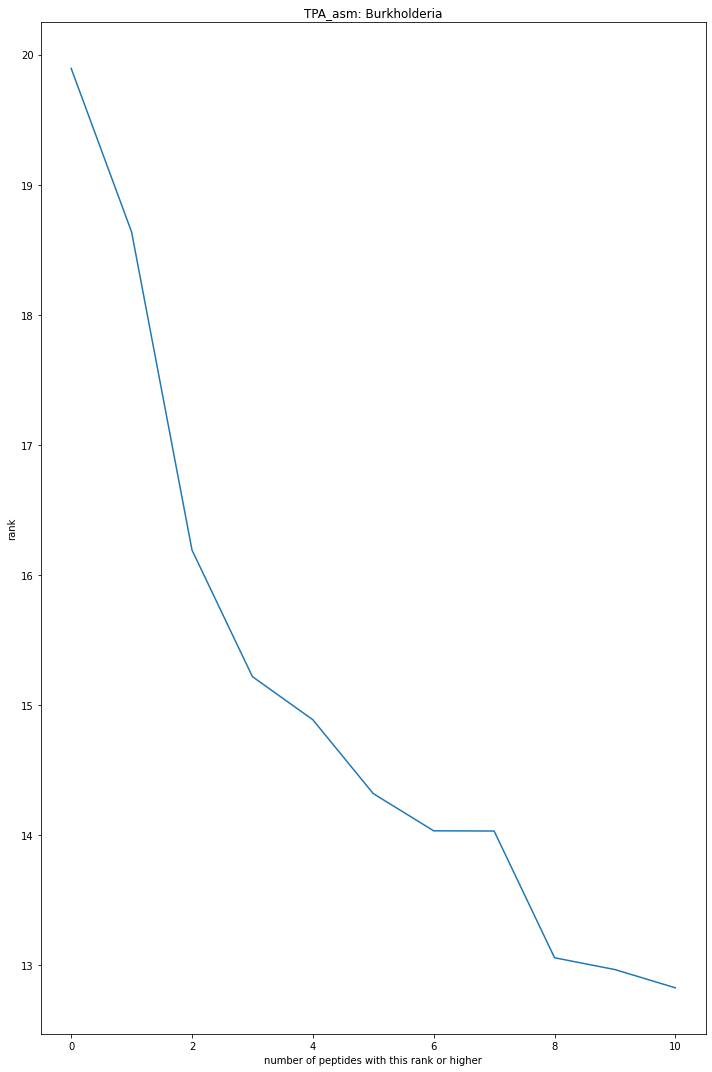

In [31]:
fig, axs = plt.subplots(len(genomeArr), 1, figsize=(10,15))

for i in range(0, len(genomeArr)):
    y = genomeDict[genomeArr[i]["genome"]]["ranks"]
    x = range(0, len(y))
    axs.plot(x, y)
    axs.set_title(genomeArr[i]["genome"])
    axs.set(xlabel="number of peptides with this rank or higher", ylabel="rank")

plt.tight_layout()
plt.show()